In [ ]:
import os
import random
random.seed(0)
!unzip './dataset/pneumothoraxdataset.zip'

In [ ]:
%tensorflow_version 1.x
import shutil
import os
import cv2
import pandas as pd
import numpy as np
import seaborn as sns
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from skimage.transform import resize
import tensorflow as tf
import keras.backend as K
from keras.losses import binary_crossentropy

from keras.preprocessing.image import load_img
from keras import Model
from keras.callbacks import  ModelCheckpoint
from keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate, Dropout,BatchNormalization
from keras.layers import Conv2D, Concatenate, MaxPooling2D
from keras.layers import UpSampling2D, Dropout, BatchNormalization
from tqdm import tqdm_notebook
from keras import initializers
from keras import regularizers
from keras import constraints
from keras.utils import conv_utils
from keras.utils.data_utils import get_file
from keras.engine.topology import get_source_inputs
from keras.engine import InputSpec
from keras import backend as K
from keras.layers import LeakyReLU
from keras.layers import ZeroPadding2D
from keras.losses import binary_crossentropy
import keras.callbacks as callbacks
from keras.callbacks import Callback
from keras.applications.xception import Xception
from keras.layers import multiply

import keras
from keras import optimizers
from keras.utils.generic_utils import get_custom_objects

from keras.engine.topology import Input
from keras.engine.training import Model
from keras.layers.convolutional import Conv2D, UpSampling2D, Conv2DTranspose
from keras.layers.core import Activation, SpatialDropout2D
from keras.layers.merge import concatenate
from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import MaxPooling2D
from keras.layers import Input,Dropout,BatchNormalization,Activation,Add
from keras.regularizers import l2
from keras.layers.core import Dense, Lambda
from keras.layers.merge import concatenate, add
from keras.layers import GlobalAveragePooling2D, Reshape, Dense, multiply, Permute
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.densenet import DenseNet121

TensorFlow 1.x selected.


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


In [ ]:
import glob
train = glob.glob('/../train/*')
mask = glob.glob('/../masks/*')
test = glob.glob('/../test/*')

In [ ]:
all_mask_fn = glob.glob('/../masks/*')
mask_df = pd.DataFrame()
mask_df['file_names'] = all_mask_fn
mask_df['mask_percentage'] = 0
mask_df.set_index('file_names',inplace=True)
for fn in all_mask_fn:
    mask_df.loc[fn,'mask_percentage'] = np.array(Image.open(fn)).sum()/(256*256*255) #255 is bcz img range is 255
    
mask_df.reset_index(inplace=True)
mask_df['labels'] = 0
mask_df.loc[mask_df.mask_percentage>0,'labels'] = 1
#sns.distplot(mask_df.mask_percentage.values)

In [ ]:
all_train_fn = glob.glob('/../train/*')
total_samples = len(all_train_fn)
idx = np.arange(total_samples)
train_fn,val_fn = train_test_split(all_train_fn,stratify=mask_df.labels,test_size=0.1,random_state=10)

print('No. of train files:', len(train_fn))
print('No. of val files:', len(val_fn))

masks_train_fn = [fn.replace('/train/','/masks/') for fn in train_fn]    
masks_val_fn = [fn.replace('/train/','/masks/') for fn in val_fn]

No. of train files: 10842
No. of val files: 1205


In [ ]:
!mkdir '/../im_train'
train_dir = '/../im_train'
for full_fn in train_fn:
    fn = full_fn.split('/')[-1]
    shutil.move(full_fn,os.path.join(train_dir,fn))
    
!mkdir '/../mask_train'
train_dir = '/content/mask_train'
for full_fn in masks_train_fn:
    fn = full_fn.split('/')[-1]
    shutil.move(full_fn,os.path.join(train_dir,fn))
    
!mkdir '/../im_val'
train_dir = '/../im_val'
for full_fn in val_fn:
    fn = full_fn.split('/')[-1]
    shutil.move(full_fn,os.path.join(train_dir,fn))
    
!mkdir '/../mask_val'
train_dir = '/../mask_val'
for full_fn in masks_val_fn:
    fn = full_fn.split('/')[-1]
    shutil.move(full_fn,os.path.join(train_dir,fn))

In [ ]:
def convolution_block(x, filters, size, strides=(1,1), padding='same', activation=True):
    x = Conv2D(filters, size, strides=strides, padding=padding)(x)
    x = BatchNormalization()(x)
    if activation == True:
        x = LeakyReLU(alpha=0.1)(x)
    return x

def residual_block(blockInput, num_filters=16):
    x = LeakyReLU(alpha=0.1)(blockInput)
    x = BatchNormalization()(x)
    blockInput = BatchNormalization()(blockInput)
    x = convolution_block(x, num_filters, (3,3) )
    x = convolution_block(x, num_filters, (3,3), activation=False)
    x = Add()([x, blockInput])
    return x
  
from efficientnet import EfficientNetB4

def UEfficientNet(input_shape=(None, None, 3),dropout_rate=0.1):

    backbone = EfficientNetB4(weights='imagenet',
                            include_top=False,
                            input_shape=input_shape)
    input = backbone.input
    start_neurons = 8

    conv4 = backbone.layers[342].output
    conv4 = LeakyReLU(alpha=0.1)(conv4)
    pool4 = MaxPooling2D((2, 2))(conv4)
    pool4 = Dropout(dropout_rate)(pool4)
    
     # Middle
    convm = Conv2D(start_neurons * 32, (3, 3), activation=None, padding="same",name='conv_middle')(pool4)
    convm = residual_block(convm,start_neurons * 32)
    convm = residual_block(convm,start_neurons * 32)
    convm = LeakyReLU(alpha=0.1)(convm)
    
    deconv4 = Conv2DTranspose(start_neurons * 16, (3, 3), strides=(2, 2), padding="same")(convm)
    deconv4_up1 = Conv2DTranspose(start_neurons * 16, (3, 3), strides=(2, 2), padding="same")(deconv4)
    deconv4_up2 = Conv2DTranspose(start_neurons * 16, (3, 3), strides=(2, 2), padding="same")(deconv4_up1)
    deconv4_up3 = Conv2DTranspose(start_neurons * 16, (3, 3), strides=(2, 2), padding="same")(deconv4_up2)
    uconv4 = concatenate([deconv4, conv4])
    uconv4 = Dropout(dropout_rate)(uconv4) 
    
    uconv4 = Conv2D(start_neurons * 16, (3, 3), activation=None, padding="same")(uconv4)
    uconv4 = residual_block(uconv4,start_neurons * 16)
#     uconv4 = residual_block(uconv4,start_neurons * 16)
    uconv4 = LeakyReLU(alpha=0.1)(uconv4)  #conv1_2
    
    deconv3 = Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(uconv4)
    deconv3_up1 = Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(deconv3)
    deconv3_up2 = Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(deconv3_up1)
    conv3 = backbone.layers[154].output
    uconv3 = concatenate([deconv3,deconv4_up1, conv3])    
    uconv3 = Dropout(dropout_rate)(uconv3)
    
    uconv3 = Conv2D(start_neurons * 8, (3, 3), activation=None, padding="same")(uconv3)
    uconv3 = residual_block(uconv3,start_neurons * 8)
#     uconv3 = residual_block(uconv3,start_neurons * 8)
    uconv3 = LeakyReLU(alpha=0.1)(uconv3)

    deconv2 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="same")(uconv3)
    deconv2_up1 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="same")(deconv2)
    conv2 = backbone.layers[92].output
    uconv2 = concatenate([deconv2,deconv3_up1,deconv4_up2, conv2])
        
    uconv2 = Dropout(0.1)(uconv2)
    uconv2 = Conv2D(start_neurons * 4, (3, 3), activation=None, padding="same")(uconv2)
    uconv2 = residual_block(uconv2,start_neurons * 4)
#     uconv2 = residual_block(uconv2,start_neurons * 4)
    uconv2 = LeakyReLU(alpha=0.1)(uconv2)
    
    deconv1 = Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(uconv2)
    conv1 = backbone.layers[30].output
    uconv1 = concatenate([deconv1,deconv2_up1,deconv3_up2,deconv4_up3, conv1])
    
    uconv1 = Dropout(0.1)(uconv1)
    uconv1 = Conv2D(start_neurons * 2, (3, 3), activation=None, padding="same")(uconv1)
    uconv1 = residual_block(uconv1,start_neurons * 2)
#     uconv1 = residual_block(uconv1,start_neurons * 2)
    uconv1 = LeakyReLU(alpha=0.1)(uconv1)
    
    uconv0 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv1)   
    uconv0 = Dropout(0.1)(uconv0)
    uconv0 = Conv2D(start_neurons * 1, (3, 3), activation=None, padding="same")(uconv0)
    uconv0 = residual_block(uconv0,start_neurons * 1)
#     uconv0 = residual_block(uconv0,start_neurons * 1)
    uconv0 = LeakyReLU(alpha=0.1)(uconv0)
    
    uconv0 = Dropout(dropout_rate/2)(uconv0)
    output_layer = Conv2D(1, (1,1), padding="same", activation="sigmoid")(uconv0)    
    
    model = Model(input, output_layer)
    model.name = 'u-xception'

    return model

In [ ]:
tf.keras.backend.clear_session()
def Get_Segmentation():
  img_size = 256
  segmentation = UEfficientNet(input_shape=(img_size,img_size,3),dropout_rate=0.3)
  segmentation.load_weights('./models/segmentation.hdf5')
  return segmentation

In [ ]:
def get_chexnet_model():
    input_shape = (256, 256, 3)
    img_input = Input(shape=input_shape)
    base_weights = 'imagenet'

    # create the base pre-trained model
    base_model = DenseNet121(
        include_top=False,
        input_tensor=img_input,
        input_shape=input_shape,
        weights=base_weights,
        pooling='avg'
    )

    x = base_model.output
    # add a logistic layer -- let's say we have 14 classes
    predictions = Dense(
        14,
        activation='sigmoid',
        name='predictions')(x)

    # this is the model we will use
    model = Model(
        inputs=img_input,
        outputs=predictions,
    )

    # load chexnet weights
    model.load_weights('./models/best_weights.h5')

    # return model
    return base_model, model

In [ ]:
def Get_Classifier():
  base, model = get_chexnet_model()
  x = Dense(256, activation='relu', kernel_initializer='he_normal')(model.layers[-2].output)
  X = keras.layers.Dropout(0.5)(x)
  x = Dense(256, activation='relu', kernel_initializer='he_normal')(model.layers[-2].output)
  x = Dense(2, activation='softmax', kernel_initializer='he_normal')(x)

  classifier =  Model(model.input, x)
  classifier.load_weights('./models/classifier.hdf5')
  return classifier

In [ ]:
image = [path.replace('/masks/','/train/') for path in mask_df['file_names']]
mask_df['image'] = image
id = np.array(mask_df[mask_df.labels==1].index)
mask_df.head()

,file_names,mask_percentage,labels,image
0,/content/masks/1.2.276.0.7230010.3.1.4.8323329...,0.000000,0,/content/train/1.2.276.0.7230010.3.1.4.8323329...
1,/content/masks/1.2.276.0.7230010.3.1.4.8323329...,0.005577,1,/content/train/1.2.276.0.7230010.3.1.4.8323329...
2,/content/masks/1.2.276.0.7230010.3.1.4.8323329...,0.071230,1,/content/train/1.2.276.0.7230010.3.1.4.8323329...
3,/content/masks/1.2.276.0.7230010.3.1.4.8323329...,0.000000,0,/content/train/1.2.276.0.7230010.3.1.4.8323329...
4,/content/masks/1.2.276.0.7230010.3.1.4.8323329...,0.006253,1,/content/train/1.2.276.0.7230010.3.1.4.8323329...


#With plotting Original Mask:

In [ ]:
class Pipeline():
  def __init__(self, segmentation, classifier):
    self.segmentation = segmentation
    self.classifier   = classifier
  def Predict(self, ix, groundtruth):
    image = cv2.imread(mask_df.loc[ix, 'image'])
    img_clf = image/255.0
    pre_cls = np.argmax(self.classifier.predict(tf.expand_dims(img_clf, axis=0), steps=1))
    plt.imshow(image)
    if pre_cls==1:
      img_seg = self.segmentation.predict(tf.expand_dims(image, axis=0), steps=1)
      if groundtruth:
        plt.imshow(cv2.imread(mask_df.loc[ix, 'file_names'])[:,:,0], cmap='Greens', alpha = 0.2)      
      plt.imshow(img_seg[0,:,:,0], cmap='Reds', alpha = 0.2)
      plt.title("Pneumothorax is Detected.........")
    else:
      plt.title("Pneumothorax is not Detected.........")
    plt.show()

Green: Groundtruth, Red: Prediction


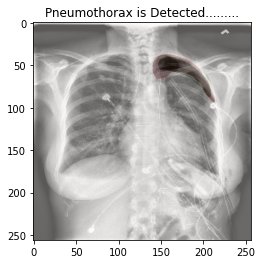

In [ ]:
ix = id[np.random.randint(len(id))]
print("Green: Groundtruth, Red: Prediction")
pipeline = Pipeline(segmentation, classifier)
pipeline.Predict(ix, groundtruth=True)

Green: Groundtruth, Red: Prediction


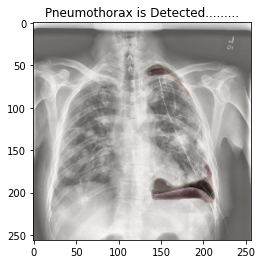

In [ ]:
ix = id[np.random.randint(len(id))]
print("Green: Groundtruth, Red: Prediction")
pipeline = Pipeline(segmentation, classifier)
pipeline.Predict(ix, groundtruth=True)

##Final Production Pipeline:- (Without plotting Original Mask)


In [ ]:
class Pipeline():
  def __init__(self, segmentation, classifier):
    self.segmentation = segmentation
    self.classifier   = classifier
  def Predict(self, ix):
    image = cv2.imread(mask_df.loc[ix, 'image'])
    img_clf = image/255.0
    pre_cls = np.argmax(self.classifier.predict(tf.expand_dims(img_clf, axis=0), steps=1))
    plt.imshow(image)
    if pre_cls==1:
      img_seg = self.segmentation.predict(tf.expand_dims(image, axis=0), steps=1)
      plt.imshow(img_seg[0,:,:,0], cmap='Reds', alpha = 0.2)
      plt.title("Pneumothorax is Detected.........")
    else:
      plt.title("Pneumothorax is not Detected.........")
    plt.show()

Red: Prediction


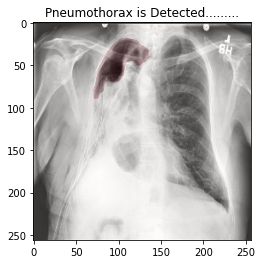

In [ ]:
ix = id[np.random.randint(len(id))]
print("Red: Prediction")
pipeline = Pipeline(segmentation, classifier)
pipeline.Predict(ix)

Red: Prediction


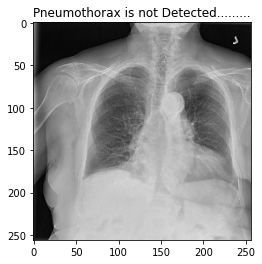

In [ ]:
ix = np.random.randint(len(mask_df))
print("Red: Prediction")
pipeline = Pipeline(segmentation, classifier)
pipeline.Predict(ix)

Red: Prediction


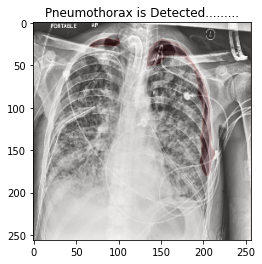

In [ ]:
ix = id[np.random.randint(len(id))]
print("Red: Prediction")
pipeline = Pipeline(segmentation, classifier)
pipeline.Predict(ix)